# Explain invariant descriptors in two slides (or three)

## Description of slides

- First slide: coordinate arrays are not invariant (linear regression).
- Second slide: invariant descriptors are (linear regression).
- Third slide: kernel regression.

**First slide.** Two rows, four columns.

First row.

- 1st column. 3D view of a `molecule` (`ase.Atom`).
- 2nd column. `molecule.arrays` (coordinates, species) of the molecule.
- 3rd column. `plot_feature_matrix`(coordinate arrays of molecules as feature vectors)
- 4th column. coefficient vector = target (tall rectangle = tall rectangle).

Second row. The same, but all molecules are randomly rotated, translated, index-permuted. The 1st, 2nd and 3rd column look different.

Slide schema.

```
/ -------------------------------------------------------------------------------------------------- \
|  molecule 3D             | coordinates      | feature matrix | coefficient vector = target vector  |
|                                                                                                    |
|  molecule 3D transformed | "Inv. desc. ..." | feature matrix | coefficient vector = target vector  |
\ -------------------------------------------------------------------------------------------------- /
```

**Second slide.** Two rows, four columns.

First row.

- 1st column. 3D view of the same molecule.
- 2nd column. Text: "Invariant descriptor (translation, rotation, permutation)".
- 3rd column. `plot_feature_matrix`(feature vectors from descriptor).
- 4th column. as above.

Second row. The same, but all molecules are transformed (same trafo as above). Only the 1st column looks different.

**Third slide**. Two rows, four columns.

Only one row.

- 1st column. 3D view of the same molecule.
- 2nd column. Descriptor formula.
- 3rd column. `plot_feature_matrix` (kernel matrix from feature vectors of descriptors; kernel formula on top of matrix).
- 4th column. as above.

---

The rest of the notebook is for producing the needed figures and arrays for the 1st, 2nd, 3rd columns.

## Imports

In [133]:
# ipython magic autoreload for code development: 
# makes code changes in any imported code available instantly.
# avoid having to restart the notebook kernel.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
# package imports
import numpy as np
import scipy.spatial.distance
import matplotlib.pyplot as plt
import ase
import ase.io
import ase.visualize
import dscribe.descriptors
import sklearn.linear_model
import sklearn.kernel_ridge
import sklearn.gaussian_process

In [135]:
# project imports
import sisclab22p6.features
import sisclab22p6.features_plotters

## Setup

In [136]:
# Load the molecular structures and atomization energies from the file dsgdb7ae2.xyz.
structures = ase.io.read("../../../data/ml-tutorial-1/rupp2015/dsgdb7ae2.xyz", index=":")

For conceptual visualization, limit to ~50 molecules: all with first atom = carbon, num atoms = 10.

In [137]:
def keep(structure : ase.Atoms):
    symbols = structure.get_chemical_symbols()
    if symbols[0] == 'C' and len(symbols) == 10:
        return True
    return False
def get_energy(structure: ase.Atoms):
    return float(list(structure.info.keys())[1])

In [138]:
structures, energies = list(map(list, zip(*[(struc, get_energy(struc)) for struc in structures if keep(struc)])))
y = np.array(energies)

## Plot target vector (all 4th columns)

In [139]:
sisclab22p6.features_plotters.plot_feature_matrix(y.reshape(-1,1), transpose=False)#, filepath='fig/target_vector.pdf')
plt.savefig('fig/target_vector.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

## First slide

### First row

#### 1st column

In [140]:
structure = structures[0]
ase.visualize.view(structure, viewer='x3d')

#### 2nd column

In [141]:
print(structure.numbers)      
print(structure.positions)      

[6 6 7 1 1 1 1 1 1 1]
[[ 0.95628  0.0636   0.06449]
 [ 2.48002  0.04243  0.06108]
 [ 2.97149 -1.25011 -0.40366]
 [ 0.59671  1.05541  0.41117]
 [ 0.5652  -0.71738  0.75053]
 [ 0.56973 -0.12235 -0.96007]
 [ 2.85549  0.24276  1.08904]
 [ 2.85058  0.84021 -0.61869]
 [ 2.65113 -1.99901  0.25317]
 [ 4.01717 -1.23196 -0.38295]]


#### 3rd column

In [142]:
num_samples = len(structures)
num_atoms_max = max(s.get_global_number_of_atoms() for s in structures)
num_features = 1*num_atoms_max + 3*num_atoms_max

X_coordinates = np.zeros((num_samples, num_features))

In [143]:
def get_coordinate_feature_matrix(structures) -> np.ndarray:
    num_samples = len(structures)
    num_atoms_max = max(s.get_global_number_of_atoms() for s in structures)
    num_features = 1*num_atoms_max + 3*num_atoms_max

    X_coordinates = np.zeros((num_samples, num_features))
    
    for i_sample, structure in enumerate(structures):
        structure.center()
        # create coordinate feature space matrix
        # features = atomic numbers plus xyz coordinates of each atom
        # pad each section with zeroes so that feature vectors for molecules with different number of atoms have same length
        num_atoms = structure.get_global_number_of_atoms()
        atomic_numbers = structure.numbers
        positions_flattened = structure.positions.flatten()    

        # make scale atomic numbers to same 'size' as coordinates in feature space
        norm1 = np.linalg.norm(atomic_numbers, ord=0)
        norm2 = np.linalg.norm(positions_flattened, ord=0)
        atomic_numbers = atomic_numbers * (norm2 / norm1)  

        # concatenate into feature vector
        feature_vector = np.zeros((num_features,))
        feature_vector[:num_atoms] = atomic_numbers
        feature_vector[num_atoms_max : num_atoms_max + 3*num_atoms] = positions_flattened    

        # add to feature matrix
        X_coordinates[i_sample,:] = feature_vector
        
    return X_coordinates

In [144]:
X_coordinates = get_coordinate_feature_matrix(structures)

In [145]:
sisclab22p6.features_plotters.plot_feature_matrix(X_coordinates, transpose=False)#, filepath='fig/X_coordinates.pdf')
plt.savefig('fig/X_coordinates.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

#### 4th column

In [146]:
# compute coefficients vector, lin reg
model = sklearn.linear_model.LinearRegression()

In [147]:
model.fit(X_coordinates, y)

LinearRegression()

In [148]:
sisclab22p6.features_plotters.plot_feature_matrix(model.coef_.reshape(-1,1), transpose=False, cmap='magma')#, filepath='fig/coef_linear_coordinates.pdf')
plt.savefig('fig/coef_linear_coordinates.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Second row

#### 1st column

In [149]:
def transform(structures : list) -> list:
    """Randomly rotate, translate, permute molecules. (permute: H atoms indices)."""

    structures_transformed = [struc.copy() for struc in structures]

    # tranlsate randomly
    _ = [struc.translate(np.random.randint(low=-10,high=10,size=(1,)) * np.random.rand(3)) for struc in structures]
    # _ = [struc.center() for struc in structures] # cheating: otherwise view(structure) will show blank screen

    # rotate randomly
    _ = [struc.rotate(np.random.randint(low=-360, high=360, size=3), 'x') for struc in structures_transformed]

    # permute randomly: swap indices of all H atoms
    for structure in structures_transformed:
        idx_of_H_atoms = np.where(structure.numbers == 1)[0]
        idx_of_H_atoms_permuted = np.random.permutation(idx_of_H_atoms)
        for idx1, idx2 in zip(idx_of_H_atoms, idx_of_H_atoms_permuted):
            structure.positions[[idx1, idx2]] = structure.positions[[idx2, idx1]]
            
    return structures_transformed

In [150]:
structures_transformed = transform(structures)
structure = structures_transformed[0]
ase.visualize.view(structure, viewer='x3d')

#### 2nd column

In [151]:
print(structure.numbers)      
print(structure.positions)      

[6 6 7 1 1 1 1 1 1 1]
[[-0.09995568 -1.43420332  0.04116089]
 [-0.54732566  0.02213734  0.00687753]
 [ 0.52260982  0.87290608 -0.50264802]
 [-0.92653554 -2.0705965   0.42186305]
 [-1.43366761  0.11191422 -0.65809837]
 [ 0.17520183 -1.77305947 -0.98020406]
 [ 1.34658254  0.81530476  0.13973693]
 [ 0.77681955 -1.54847962  0.71326977]
 [ 0.18496092  1.8629556  -0.50224637]
 [-0.83270012  0.34613962  1.03225334]]


#### 3rd column

In [152]:
X_coordinates_transformed = get_coordinate_feature_matrix(structures_transformed)

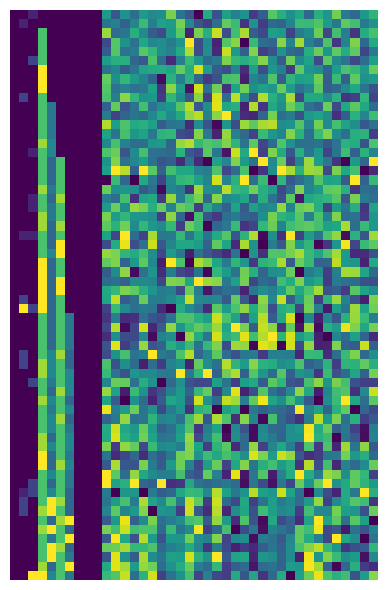

In [153]:
sisclab22p6.features_plotters.plot_feature_matrix(X_coordinates_transformed, transpose=False)#, filepath='fig/X_coordinates_transformed.pdf')
plt.savefig('fig/X_coordinates_transformed.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

#### 4th column

In [154]:
# compute coefficients vector, lin reg
model = sklearn.linear_model.LinearRegression()

In [155]:
model.fit(X_coordinates_transformed, y)

LinearRegression()

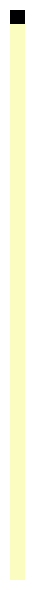

In [156]:
sisclab22p6.features_plotters.plot_feature_matrix(model.coef_.reshape(-1,1), transpose=False, cmap='magma')#, filepath='fig/coef_linear_coordinates_transformed.pdf')
plt.savefig('fig/coef_linear_coordinates_transformed.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

## Second slide

### First row

#### 1st column

Same as on first slide.

#### 2nd column

Rather than printing the feature vector, on slide, just put text 

```
Invariant descriptor
(translation
rotation
permuation)
```

This is not about explaining a particular descriptor, but the concept of invariance.

Coulomb Matrix.

In [157]:
# Setting up the CM descriptor
coulomb_matrix = dscribe.descriptors.CoulombMatrix(
    n_atoms_max=num_atoms_max,
    permutation='sorted_l2'
)

In [158]:
X_coulomb = coulomb_matrix.create(structures, n_jobs=-1)

In [159]:
x0 = X_coulomb[0]
x0.reshape((num_atoms_max, num_atoms_max))

array([[53.3587074 , 28.79019007, 17.13776192,  6.68974166,  6.69188848,
         3.3256897 ,  3.31078635,  2.57217606,  2.58200896,  2.05359402],
       [28.79019007, 36.8581052 , 23.62373888,  2.91604046,  2.93327082,
         5.39718754,  5.39292   ,  2.76196139,  2.76198495,  2.76890532],
       [17.13776192, 23.62373888, 36.8581052 ,  2.24191757,  1.78903521,
         2.77997419,  2.7708972 ,  5.402284  ,  5.40185203,  5.40307146],
       [ 6.68974166,  2.91604046,  2.24191757,  0.5       ,  0.59140756,
         0.3359359 ,  0.41645075,  0.40028682,  0.32745498,  0.27141178],
       [ 6.69188848,  2.93327082,  1.78903521,  0.59140756,  0.5       ,
         0.41847253,  0.41918298,  0.27251228,  0.27267961,  0.2386218 ],
       [ 3.3256897 ,  5.39718754,  2.77997419,  0.3359359 ,  0.41847253,
         0.5       ,  0.55272139,  0.324037  ,  0.40014924,  0.40203616],
       [ 3.31078635,  5.39292   ,  2.7708972 ,  0.41645075,  0.41918298,
         0.55272139,  0.5       ,  0.39898353

SOAP.

In [160]:
species = sisclab22p6.features.get_chemical_species(structures)
positions_carbon = [np.where(struc.numbers == 6)[0] for struc in structures]

In [161]:
soap_parameters = {
    'r_cut' : 3.5,
    # 'r_cut' : None,
    'n_max' : 2,
    'l_max' : 2,
    'sigma' : 0.5,
    'rbf'   : 'gto',
    'weighting' : None,
    # 'weighting' : {'function' : 'poly', 'r0': 4.0, 'c' : 0.5, 'm' : 1},
    # 'weighting' : {'function': 'pow', 'r0': 4.0, 'c' : 0.5, 'd' : 0.5, 'm': 1},
    'crossover' : True,
    'average' : 'inner',
    'species' : species,
    'periodic' : False,
    'sparse' : False
}

In [162]:
soap = dscribe.descriptors.SOAP(**soap_parameters)
soap.get_number_of_features()

165

In [163]:
X_soap = soap.create(structures, 
                     positions=None,                     
                     # positions=positions_carbon, 
                     n_jobs=-1)

In [164]:
x0 = X_soap[0]
x0

array([ 3.24546889e-01,  1.72150344e+00,  9.13142040e+00,  8.50185319e-05,
       -2.82341020e-04,  2.13816548e-02,  1.40613921e-03, -1.57355659e-03,
        3.94304081e-02,  5.56229101e-02,  7.55060924e-01,  2.95042209e-01,
        4.00509146e+00,  2.91381009e-04, -5.55675267e-04, -1.57864578e-03,
        1.15934461e-03,  1.56900400e-03, -5.73902141e-03,  8.31654335e-04,
       -7.09655895e-04,  4.49687592e-02,  3.25587803e-01,  2.38529088e-01,
        1.72702479e+00, -3.76399541e-04,  8.38016287e-04,  1.86098680e-03,
       -2.25409994e-02,  4.95752182e-04, -4.68538918e-03,  1.01062516e-03,
        1.09737104e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

#### 3rd column

In [165]:
sisclab22p6.features_plotters.plot_feature_matrix(X_coulomb, transpose=False)#, filepath='fig/X_coulomb.pdf')
plt.savefig('fig/X_coulomb.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

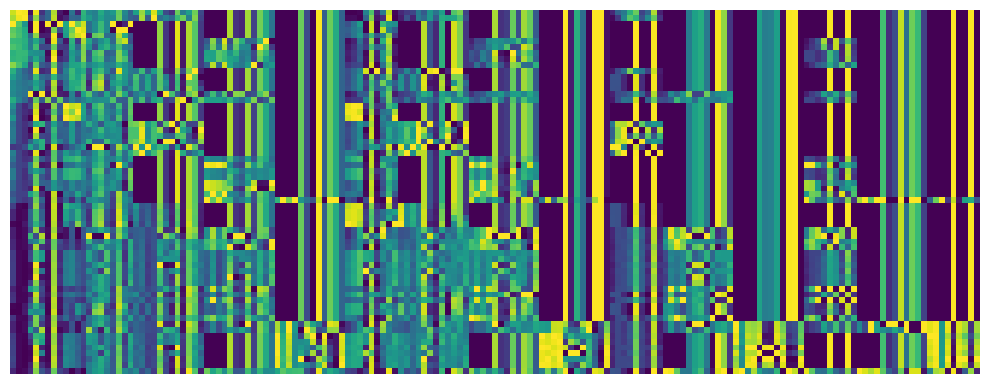

In [166]:
sisclab22p6.features_plotters.plot_feature_matrix(X_soap, transpose=False)#, filepath='fig/X_soap.pdf')
plt.savefig('fig/X_soap.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

#### 4th column

In [167]:
# compute coefficients vector, lin reg
model = sklearn.linear_model.LinearRegression()

In [168]:
model.fit(X_coulomb, y)
coef_coulomb = model.coef_
sisclab22p6.features_plotters.plot_feature_matrix(coef_coulomb.reshape(-1,1), transpose=False, cmap='magma')#, filepath='fig/coef_linear_coulomb.pdf')
plt.savefig('fig/coef_linear_coulomb.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [169]:
model.fit(X_soap, y)
coef_soap = model.coef_
sisclab22p6.features_plotters.plot_feature_matrix(coef_soap.reshape(-1,1), transpose=False, cmap='magma')#, filepath='fig/coef_linear_soap.pdf')
plt.savefig('fig/coef_linear_soap.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Second row

#### 1st column

Same as on first slide.

#### 2nd column

Same as in first column (`Invariant descriptor ...`)

#### 3rd column

In [170]:
X_coulomb_transformed = coulomb_matrix.create(structures_transformed, n_jobs=-1)

In [171]:
sisclab22p6.features_plotters.plot_feature_matrix(X_coulomb_transformed, transpose=False)#, filepath='fig/X_coulomb_transformed.pdf')
plt.savefig('fig/X_coulomb_transformed.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [172]:
X_soap_transformed = soap.create(structures, 
                                 positions=None,                     
                                 # positions=positions_carbon, 
                                 n_jobs=-1)

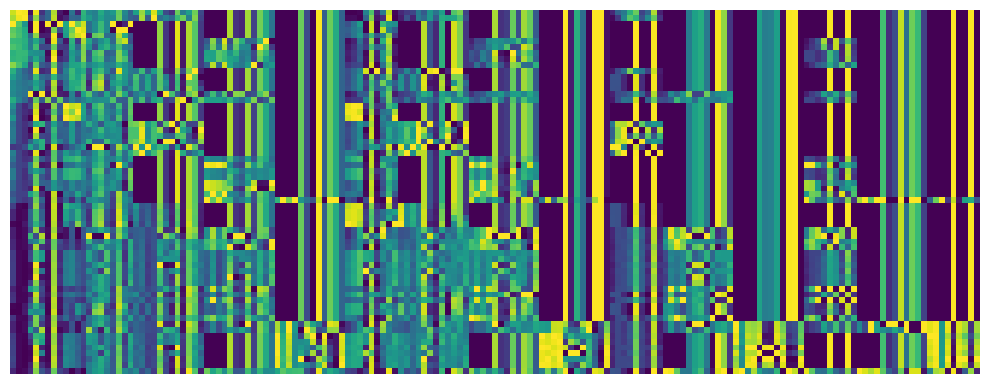

In [173]:
sisclab22p6.features_plotters.plot_feature_matrix(X_soap_transformed, transpose=False)#, filepath='fig/X_soap_transformed.pdf')
plt.savefig('fig/X_soap_transformed.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

#### 4th column

Same as 4th column above.

## Third slide

Same as on first slide.

#### 1st column

Same as on first slide.

#### 2nd column

Same as on second slide.

#### 3rd column

References for Gaussian kernel.

- [Wikipedia > Gaussian](https://en.wikipedia.org/wiki/Gaussian_function). $k(x_i,x_j) = \exp\left(-\frac{(x_i-x_j)^2}{2 \sigma^2}\right)$.
- [DScribe > SOAP](https://singroup.github.io/dscribe/latest/tutorials/descriptors/soap.html). $k(x_i,x_j) = \exp\left(-\frac{|x_i-x_j|^2}{2 \sigma^2}\right)$.
- [sklearn > `gaussian_process.kernels.RBF`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF). $k(x_i,x_j) = \exp\left(-\frac{d(x_i-x_j)^2}{2 \sigma^2}\right)$. For single samples.
- [sklearn > `metric.pairwise.rbf_kernel`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html#sklearn.metrics.pairwise.rbf_kernel). $k(x_i,x_j) = \exp\left(-\gamma ||x_i-x_j||^2\right)$. For matrices.
- [CrossValidated > How to calculate Gaussian process kernel in Numpy](https://stats.stackexchange.com/a/15817).

Note: [sklearn > `KernelRidge`](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) param `kernel` does not accept `metric.pairwise`, but `gaussian_process.kernels` objects. The former can instead be specified by their string labels, so `kernel='linear'` or `kernel="rbf_kernel"`. Internally I guess, this is then translated to `kernel=gaussian_process.kernels.RBF`.

In [174]:
def kernel_matrix_linear(X):
    return X @ X.T

In [175]:
X = X_coulomb

In [176]:
K = kernel_matrix_linear(X)

In [177]:
K2 = np.zeros_like(K)

In [178]:
n = X.shape[0]

In [179]:
XT = X.T

In [180]:
for i in range(n):
    for j in range(n):
        K2[i,j] = X[i,:] @ XT[:,j]

In [181]:
x = X[0,:]

In [182]:
def kernel_soap(x,y, zeta=1):
    # reference: https://singroup.github.io/dscribe/latest/tutorials/descriptors/soap.html
    return np.power(x@y / np.sqrt(x@x * y@y), zeta)
def kernel_matrix_soap(X, zeta=1):
    n = X.shape[0]
    XT = X.T
    K = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            K[i,j] = kernel_soap(X[i,:], XT[:,j], zeta=zeta)
    return K

In [183]:
def kernel_matrix_gaussian(X, sigma=1.0):
    # reference: https://stats.stackexchange.com/a/15817
    # this is an NxD matrix, where N is number of items and D its dimensionalites
    pairwise_dists = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X, 'euclidean'))
    return np.exp(-pairwise_dists ** 2 / sigma ** 2)

In [184]:
K_linear_coulomb = kernel_matrix_linear(X_coulomb)
K_linear_soap = kernel_matrix_linear(X_soap)
K_gaussian_coulomb = kernel_matrix_gaussian(X_coulomb)
K_gaussian_soap = kernel_matrix_gaussian(X_soap)
K_soap_soap = kernel_matrix_soap(X_soap, zeta=4)

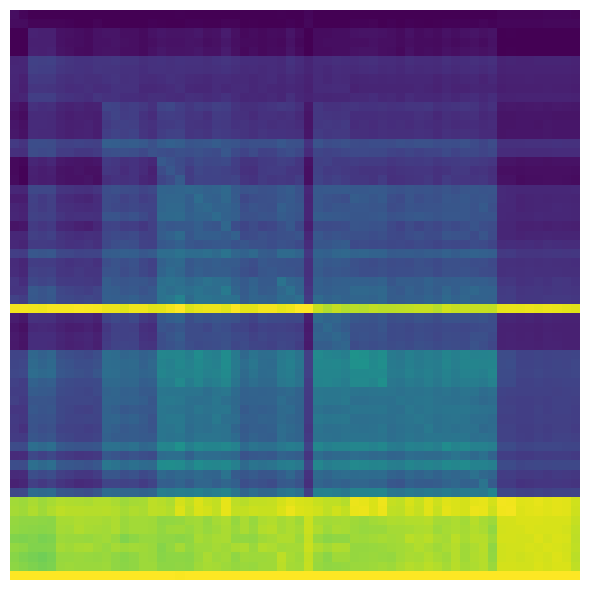

In [185]:
sisclab22p6.features_plotters.plot_feature_matrix(K_linear_coulomb, transpose=False)#, filepath='fig/K_linear_coulomb.pdf')
plt.savefig('fig/K_linear_coulomb.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [186]:
sisclab22p6.features_plotters.plot_feature_matrix(K_linear_soap, transpose=False)#, filepath='fig/K_linear_soap.pdf')
plt.savefig('fig/K_linear_soap.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [187]:
sisclab22p6.features_plotters.plot_feature_matrix(K_gaussian_coulomb, transpose=False)#, filepath='fig/K_gaussian_coulomb.pdf')
plt.savefig('fig/K_gaussian_coulomb.pdf', transparent=True, bbox_inches='tight', pad_inches=0)                                                  

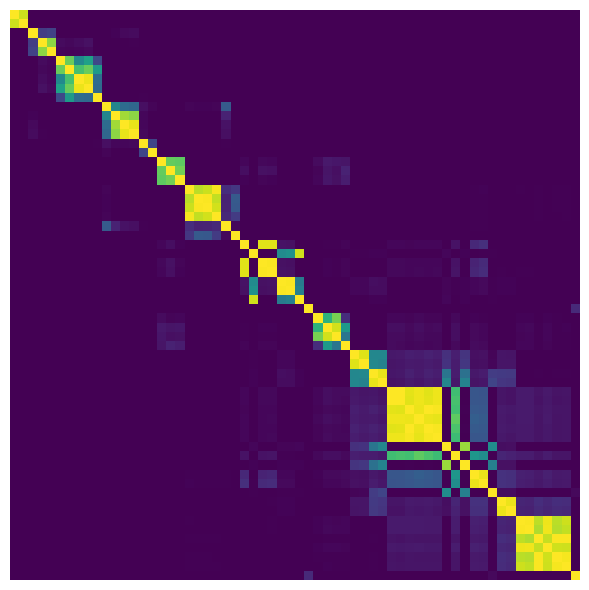

In [188]:
sisclab22p6.features_plotters.plot_feature_matrix(K_gaussian_soap, transpose=False)#, filepath='fig/K_gaussian_soap.pdf')
plt.savefig('fig/K_gaussian_soap.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

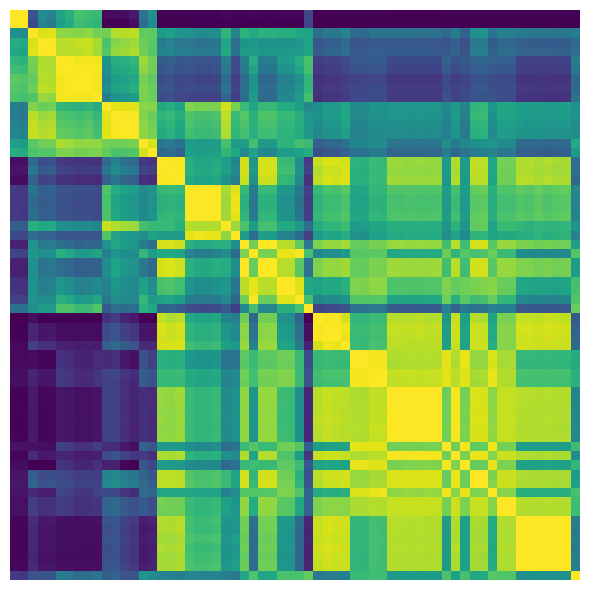

In [189]:
sisclab22p6.features_plotters.plot_feature_matrix(K_soap_soap, transpose=False)#, filepath='fig/K_soap_soap.pdf')
plt.savefig('fig/K_soap_soap.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

#### 4th column

In [190]:
kernel = sklearn.gaussian_process.kernels.RBF(length_scale=0.5)
model = sklearn.kernel_ridge.KernelRidge(kernel=kernel_soap, alpha=1, gamma=None)
# model = sklearn.kernel_ridge.KernelRidge(kernel='kernel_rbf', alpha=1, gamma=None)

In [191]:
model.fit(X_coulomb, y)
coef_coulomb = model.dual_coef_
sisclab22p6.features_plotters.plot_feature_matrix(coef_coulomb.reshape(-1,1), transpose=False, cmap='magma')#, filepath='fig/coef_kernel_coulomb.pdf')
plt.savefig('fig/coef_kernel_coulomb.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [192]:
model.fit(X_soap, y)
coef_soap = model.dual_coef_
sisclab22p6.features_plotters.plot_feature_matrix(coef_soap.reshape(-1,1), transpose=False, cmap='magma')#, filepath='fig/coef_kernel_soap.pdf')
plt.savefig('fig/coef_kernel_soap.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [193]:
model = sklearn.kernel_ridge.KernelRidge(kernel=kernel_soap, alpha=1, gamma=None)
model.fit(X_soap, y)
coef_soap = model.dual_coef_
sisclab22p6.features_plotters.plot_feature_matrix(coef_soap.reshape(-1,1), transpose=False, cmap='magma')#, filepath='fig/coef_kernel_soap_soap.pdf')
plt.savefig('fig/coef_kernel_soap_soap.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

## Additional insights

### Feature space locations in SOAP

SOAP correlates all pairs of density channels of diferent chemical species. So, the density correlation between a specific pair of elements atoms can be pin-pointed to specific features (columns) in the feature space (feature matrix).

In [194]:
species

{1, 6, 7, 8, 16}

In [195]:
carbon_oxygen = (6,8)

In [196]:
slice_carbon_oxygen = soap.get_location(carbon_oxygen)

In [197]:
X_soap_carbon_oxygen = X_soap[:,slice_carbon_oxygen]

In [198]:
sisclab22p6.features_plotters.plot_feature_matrix(X_soap_carbon_oxygen, transpose=False)#, filepath='fig/X_soap_slice_carbon-oxygen.pdf')
plt.savefig('fig/X_soap_slice_carbon-oxygen.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

This means that we can trace back predicted property through model coefficients to SOAP input feature vectors and from there to the original geometrical-chemical information of the input structures. Via the model coefficients, even the importance of certain dimensions (like the slice above) in the geometrical-chemical feature space can be ascertained and reasoned about chemically / physically --> SOAP + linear/kernel methods are NOT black-box models.